In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/HarpyTech/DSAI-MTech/refs/heads/main/TSF/Sun_Spots/train.csv")
data.Month = pd.to_datetime(data.Month, format="%m-%d-%Y")
data.set_index("Month", inplace=True)
data.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


<Axes: xlabel='Month'>

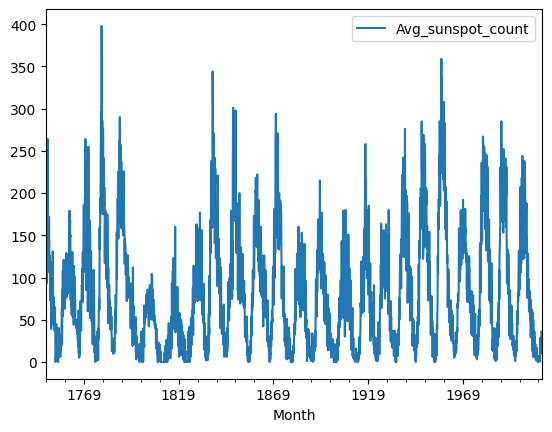

In [3]:
data.plot.line()

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Split the Data set into 80:20
train = data.iloc[:int(len(data)*0.8)//1]
test = data.iloc[int(len(data)*0.8)//1:]
train.shape, test.shape , int(len(data)*0.8)//1

((2515, 1), (629, 1), 2515)

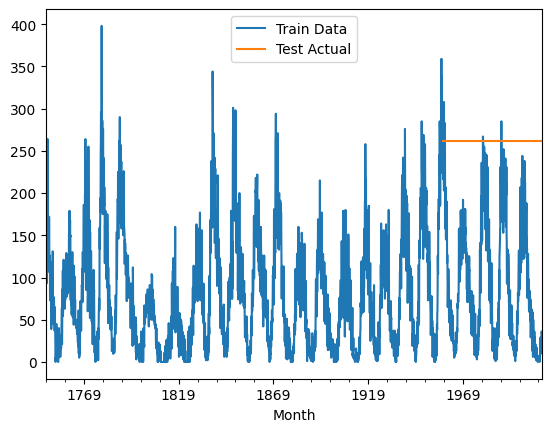

In [6]:
model_ses = SimpleExpSmoothing(train,
                               initialization_method='estimated')
model_ses_autofit = model_ses.fit(optimized=True)
ts_test_pred = model_ses_autofit.forecast(steps=len(test))
ts_test_pred.index = test.index

data.plot.line()
ts_test_pred.plot.line();
plt.legend(['Train Data', 'Test Actual', 'Test Predicted']);

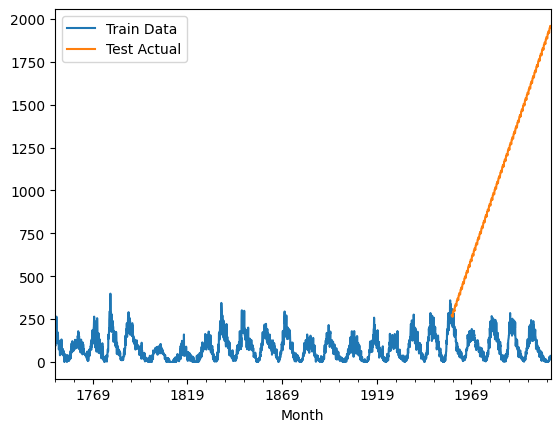

In [7]:
model_holt_winter = ExponentialSmoothing(
    train,
    trend='additive',
    seasonal='additive',
    initialization_method='estimated')
model_holt_winter_fitted = model_holt_winter.fit(optimized=True)
ts_test_pred_e = model_holt_winter_fitted.forecast(steps=len(test))

data.plot.line()
ts_test_pred_e.plot.line();
plt.legend(['Train Data', 'Test Actual', 'Test Predicted']);

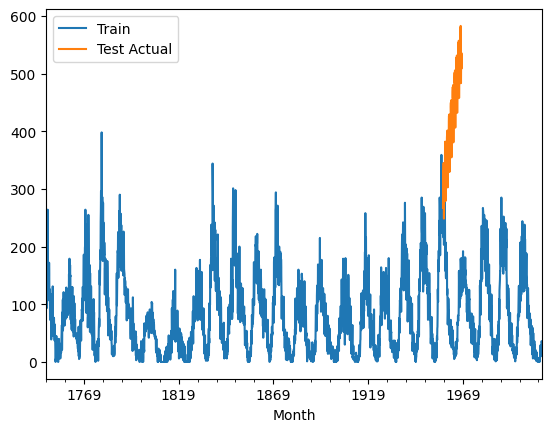

In [8]:
model = ARIMA(train,
              order=(1,1,0),
              seasonal_order=(1, 1, 0, 12),
              )
model_fit = model.fit()
model_fit.summary()

ts_test_pred = model_fit.get_forecast(steps=120).predicted_mean


data.plot.line()
ts_test_pred.plot.line()
plt.legend(['Train', 'Test Actual', 'Test Pred']);

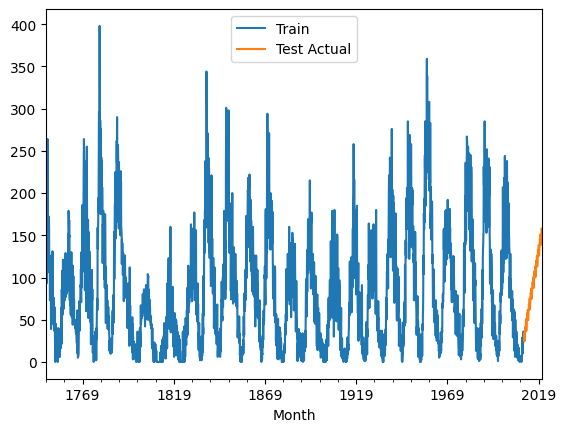

In [9]:
model = ARIMA(data,
              order=(1,1,0),
              seasonal_order=(1, 1, 0, 12),
              )
model_fit = model.fit()
model_fit.summary()

data_pred = model_fit.get_forecast(steps=120).predicted_mean

data.plot.line()
data_pred.plot.line()
plt.legend(['Train', 'Test Actual', 'Test Pred']);

Tested ARIMA(0,0,0): RMSE = 211.9980159102776
Tested ARIMA(0,0,1): RMSE = 203.63201768898585
Tested ARIMA(0,0,2): RMSE = 201.234712478982
Tested ARIMA(0,1,0): RMSE = 1098.8709309454691
Tested ARIMA(0,1,1): RMSE = 1039.408004225834
Tested ARIMA(0,1,2): RMSE = 1180.595058044862
Tested ARIMA(1,0,0): RMSE = 203.85355773019796
Tested ARIMA(1,0,1): RMSE = 236.67218905402586
Tested ARIMA(1,0,2): RMSE = 256.2065610865993
Tested ARIMA(1,1,0): RMSE = 962.806608037541
Tested ARIMA(1,1,1): RMSE = 1210.6136342394464
Tested ARIMA(1,1,2): RMSE = 1188.2187534604382
Tested ARIMA(2,0,0): RMSE = 209.74379838005225
Tested ARIMA(2,0,1): RMSE = 257.82802353376326
Tested ARIMA(2,0,2): RMSE = 255.2035643400983
Tested ARIMA(2,1,0): RMSE = 934.2620662085592
Tested ARIMA(2,1,1): RMSE = 1167.6809554219165
Tested ARIMA(2,1,2): RMSE = 548.7156039995971
Best ARIMA parameters: (0, 0, 2), RMSE = 201.234712478982


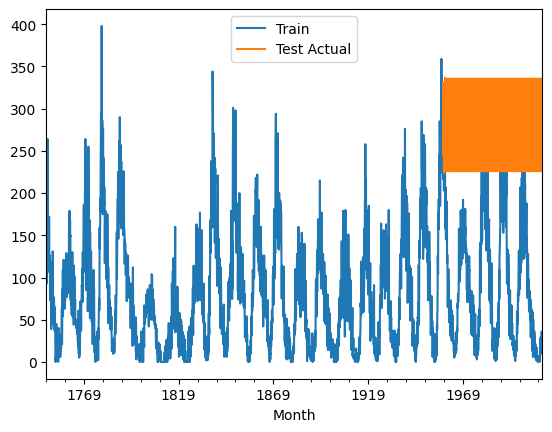

In [10]:

# Iterate through a range of p, d, and q values
p_values = range(0, 3)  # Example: try p values from 0 to 2
d_values = range(0, 2)  # Example: try d values from 0 to 1
q_values = range(0, 3)  # Example: try q values from 0 to 2

best_rmse = float('inf')
best_params = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
                model_fit = model.fit()

                # Predictions for test data
                test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

                # RMSE for test data
                test_rmse = np.sqrt(mean_squared_error(test, test_pred))

                # Check if this model has a lower RMSE
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_params = (p, d, q)
                print(f"Tested ARIMA({p},{d},{q}): RMSE = {test_rmse}")

            except Exception as e:
                print(f"Error fitting ARIMA({p},{d},{q}): {e}")

print(f"Best ARIMA parameters: {best_params}, RMSE = {best_rmse}")

# Fit the ARIMA model with the best parameters
model = ARIMA(train, order=best_params, seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()

# Predictions for test data with best model
test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

# Plot the results
data.plot.line()
test_pred.plot.line()
plt.legend(['Train', 'Test Actual', 'Test Pred']);

In [11]:
# Define a range of p, d, q, P, D, Q, and s values to search through
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)  # Seasonal p
D_values = range(0, 2)  # Seasonal d
Q_values = range(0, 2)  # Seasonal q
s = 12 # Seasonal period

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)

                            # Fit the SARIMAX model
                            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
                            model_fit = model.fit(disp=False)

                            # Predictions for test data
                            test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

                            # RMSE for test data
                            test_rmse = np.sqrt(mean_squared_error(test, test_pred))

                            if test_rmse < best_rmse:
                                best_rmse = test_rmse
                                best_order = order
                                best_seasonal_order = seasonal_order

                            print(f"Tested SARIMAX({order}, {seasonal_order}): RMSE = {test_rmse}")
                        except Exception as e:
                            print(f"Error fitting SARIMAX({order}, {seasonal_order}): {e}")


print(f"Best SARIMAX parameters: order={best_order}, seasonal_order={best_seasonal_order}, RMSE = {best_rmse}")


# Fit the best SARIMAX model
best_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
best_model_fit = best_model.fit(disp=False)

# Make predictions with the best model
test_pred = best_model_fit.get_forecast(steps=len(test)).predicted_mean

#Plot the results
data.plot.line()
test_pred.plot.line()
plt.legend([ 'Test Actual', 'Test Pred']);

Tested SARIMAX((0, 0, 0), (0, 0, 0, 12)): RMSE = 119.44402870650629
Tested SARIMAX((0, 0, 0), (0, 0, 1, 12)): RMSE = 115.80402980296341
Tested SARIMAX((0, 0, 0), (0, 1, 0, 12)): RMSE = 206.26401961312456
Tested SARIMAX((0, 0, 0), (0, 1, 1, 12)): RMSE = 209.66959098322198
Tested SARIMAX((0, 0, 0), (1, 0, 0, 12)): RMSE = 102.13924651660182
Tested SARIMAX((0, 0, 0), (1, 0, 1, 12)): RMSE = 105.29295235648122
Tested SARIMAX((0, 0, 0), (1, 1, 0, 12)): RMSE = 211.9980159102776
Tested SARIMAX((0, 0, 0), (1, 1, 1, 12)): RMSE = 72.16105719221548
Tested SARIMAX((0, 0, 1), (0, 0, 0, 12)): RMSE = 119.07125122719097
Tested SARIMAX((0, 0, 1), (0, 0, 1, 12)): RMSE = 115.61055946336566
Tested SARIMAX((0, 0, 1), (0, 1, 0, 12)): RMSE = 207.02629115911725
Tested SARIMAX((0, 0, 1), (0, 1, 1, 12)): RMSE = 201.91865102900658
Tested SARIMAX((0, 0, 1), (1, 0, 0, 12)): RMSE = 106.07514077278815
Tested SARIMAX((0, 0, 1), (1, 0, 1, 12)): RMSE = 105.95541221072992
Tested SARIMAX((0, 0, 1), (1, 1, 0, 12)): RMSE = 2

KeyboardInterrupt: 

In [12]:
# Fit the SARIMAX model
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,11))
model_fit = model.fit(disp=False)

# Predictions for test data
test_pred = model_fit.get_forecast(steps=len(test)).predicted_mean

# RMSE for test data
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f"Best SARIMAX parameters: order=(2,1,2), seasonal_order=(1,1,1,11), RMSE = {test_rmse}")


Best SARIMAX parameters: order=(2,1,2), seasonal_order=(1,1,1,11), RMSE = 192.63228984669544


In [21]:
indexes = train.index
values = train['Avg_sunspot_count'].squeeze()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmx8b8pp2/pbvd65r4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmx8b8pp2/sxq1qcja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81008', 'data', 'file=/tmp/tmpmx8b8pp2/pbvd65r4.json', 'init=/tmp/tmpmx8b8pp2/sxq1qcja.json', 'output', 'file=/tmp/tmpmx8b8pp2/prophet_modelazyx6fol/prophet_model-20250209165526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:55:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:55:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


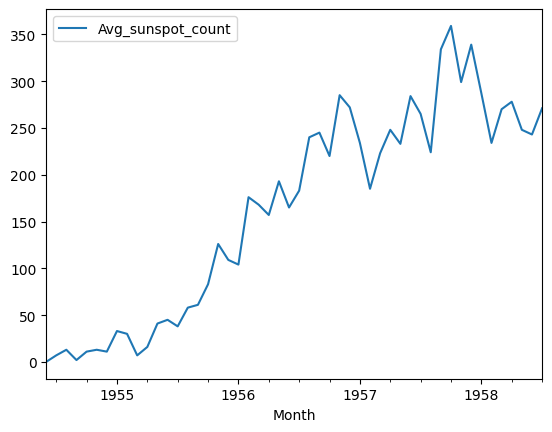

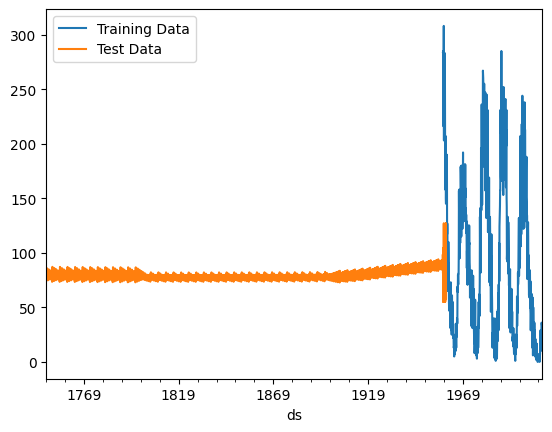

In [23]:
# If we are not satisfied with SARIMA results, this is another model. It is out of syllabus.
from prophet import Prophet

df = pd.DataFrame({ 'ds':indexes, 'y': values})

model_prophet = Prophet(seasonality_mode='additive',
                       changepoint_prior_scale=0.01)
model_prophet.fit(df)

forecast_df = model_prophet.make_future_dataframe(periods=len(test))
test_y_pred = model_prophet.predict(forecast_df).set_index('ds')['yhat']
train.tail(50).plot.line()
test.plot.line()
test_y_pred.plot.line()
plt.legend(['Training Data','Test Data','Forecasted Data'])

In [25]:
test_y_pred.head(10)

,yhat
ds,
1749-01-01,77.996434
1749-02-01,75.657114
1749-03-01,74.204592
1749-04-01,79.014286
1749-05-01,86.079884
1749-06-01,80.823194
1749-07-01,77.651291
1749-08-01,78.016262
1749-09-01,78.923860


DEBUG:cmdstanpy:input tempfile: /tmp/tmpmx8b8pp2/sy44e0oh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmx8b8pp2/rslnc0i3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26936', 'data', 'file=/tmp/tmpmx8b8pp2/sy44e0oh.json', 'init=/tmp/tmpmx8b8pp2/rslnc0i3.json', 'output', 'file=/tmp/tmpmx8b8pp2/prophet_modelsozmmomt/prophet_model-20250209165929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 74.81621425929052


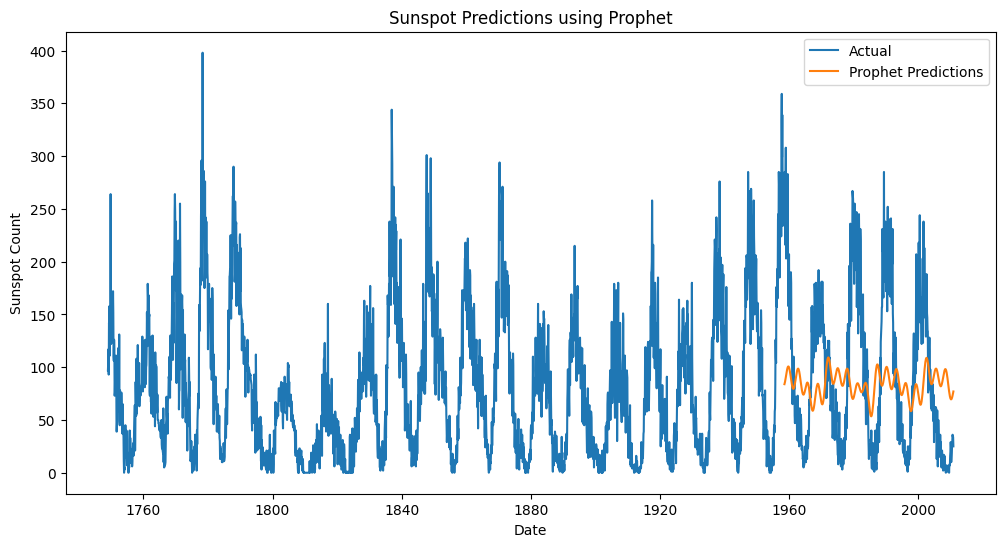

In [26]:
# prompt: for the above  time series data, we couldn't get good Results using SARIMAX, lets  apply Prophet model

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

# Prepare the data for Prophet
df_prophet = pd.DataFrame({'ds': data.index, 'y': data['Avg_sunspot_count']})

# Initialize and fit the Prophet model
model_prophet = Prophet(seasonality_mode='additive',
                       yearly_seasonality=True,
                       weekly_seasonality=False,
                       daily_seasonality=False)
model_prophet.fit(df_prophet)

# Create future dataframe for predictions
future = model_prophet.make_future_dataframe(periods=len(test))

# Make predictions
forecast = model_prophet.predict(future)

# Extract predictions for the test set
test_predictions = forecast.iloc[-len(test):]['yhat']
test_predictions.index = test.index


# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, test_predictions))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Avg_sunspot_count'], label='Actual')
plt.plot(test_predictions.index, test_predictions, label='Prophet Predictions')
plt.legend()
plt.title('Sunspot Predictions using Prophet')
plt.xlabel('Date')
plt.ylabel('Sunspot Count')
plt.show()


In [28]:
future

,ds
0,1749-01-01
1,1749-02-01
2,1749-03-01
3,1749-04-01
4,1749-05-01
...,...
3768,2012-08-17
3769,2012-08-18
3770,2012-08-19
3771,2012-08-20


In [ ]:
|data_pred = ts_test_pred # Change to Predeicted values Variable
final_result = pd.DataFrame()
final_result["Month"] = data_pred.index
final_result["Avg_sunspot_count"] = data_pred.values // 1
final_result.Avg_sunspot_count = final_result.Avg_sunspot_count.astype(int)
final_format = "%m-%d-%Y"
date_format = "%Y-%m-%d"
final_result.Month = [pd.to_datetime(date, format=date_format).strftime(final_format) for date in final_result.Month]
final_result.to_csv("result_TSF.csv", index=False)

In [29]:
data.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


In [30]:
data.tail()

,Avg_sunspot_count
Month,
2010-08-01,30
2010-09-01,36
2010-10-01,34
2010-11-01,34
2010-12-01,25


In [31]:
# prompt: generate the Dates for 2011 and 2020 year the format should be 2010-12-01, only start of the month is required.

import pandas as pd

# Create date ranges for 2011 and 2020
dates_ranges = pd.date_range(start='2011-01-01', end='2020-12-01', freq='MS')
# dates_2020 = pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS')


# Format the dates as 'YYYY-MM-DD'
formatted_dates = dates_ranges.strftime('%Y-%m-%d')

# Print the formatted dates
formatted_dates


Index(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-01',
       '2011-06-01', '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-01',
       ...
       '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
      dtype='object', length=120)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmx8b8pp2/e6zg5ngp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmx8b8pp2/_9vsrfhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92221', 'data', 'file=/tmp/tmpmx8b8pp2/e6zg5ngp.json', 'init=/tmp/tmpmx8b8pp2/_9vsrfhf.json', 'output', 'file=/tmp/tmpmx8b8pp2/prophet_modelvx7a29o6/prophet_model-20250209173737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


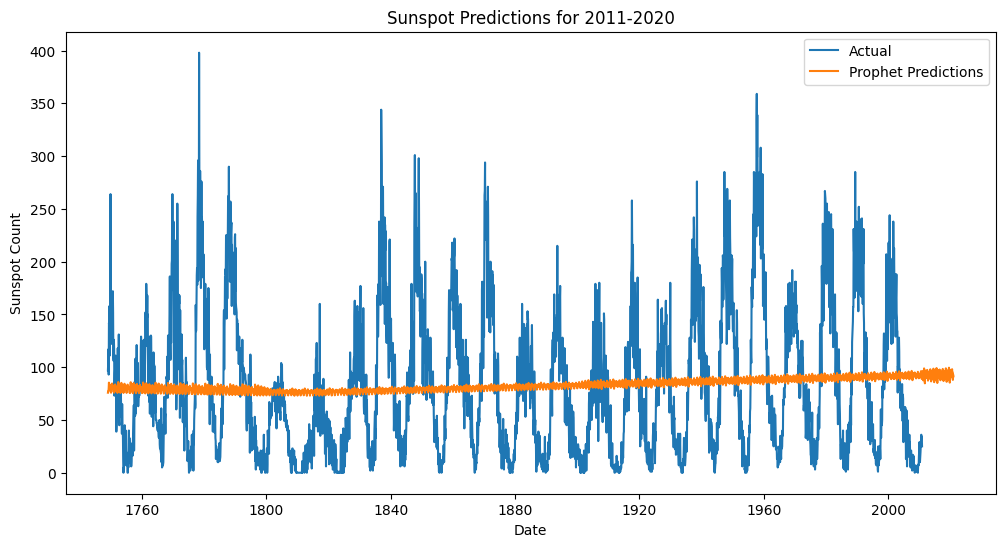

In [54]:
# prompt: apply porphet model  to data set and predict for the above dates_ranges

import pandas as pd
# Prepare the data for Prophet
df_prophet = pd.DataFrame({'ds': data.index, 'y': data['Avg_sunspot_count']})

# Initialize and fit the Prophet model
model_prophet = Prophet(seasonality_mode='additive',
                       yearly_seasonality=True,
                       weekly_seasonality=False,
                       daily_seasonality=False,
                      changepoint_prior_scale=0.01)
model_prophet.fit(df_prophet)

# Create future dataframe for predictions
future = model_prophet.make_future_dataframe(periods=len(formatted_dates) + 1, freq="M", include_history=True) # Use formatted_dates here

# Make predictions
forecast = model_prophet.predict(future)

# Extract predictions for the specified date range
predictions = forecast #.set_index('ds')

# # Create the final result DataFrame
# final_result = pd.DataFrame({'Month': predictions.index,
#                             'Avg_sunspot_count': predictions.values.astype(int)})

# # Format the date
# final_result['Month'] = final_result['Month'].dt.strftime('%m-%d-%Y')


# # Save the result
# final_result.to_csv('result_TSF.csv', index=False)

#Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Avg_sunspot_count'], label='Actual')
plt.plot(predictions['ds'], predictions['yhat'], label='Prophet Predictions')
plt.legend()
plt.title('Sunspot Predictions for 2011-2020')
plt.xlabel('Date')
plt.ylabel('Sunspot Count')
plt.show()


In [45]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3260,2020-08-31,79.910985,-3.706869,169.185860,79.101993,80.970017,1.233935,1.233935,1.233935,1.233935,1.233935,1.233935,0.0,0.0,0.0,81.144920
3261,2020-09-30,79.878275,-9.065422,167.350669,79.056355,80.960698,1.594594,1.594594,1.594594,1.594594,1.594594,1.594594,0.0,0.0,0.0,81.472869
3262,2020-10-31,79.844475,-12.448419,165.983956,79.013241,80.946385,-5.778875,-5.778875,-5.778875,-5.778875,-5.778875,-5.778875,0.0,0.0,0.0,74.065599
3263,2020-11-30,79.811765,-10.327846,160.599163,78.963730,80.926278,-0.740740,-0.740740,-0.740740,-0.740740,-0.740740,-0.740740,0.0,0.0,0.0,79.071025
3264,2020-12-31,79.777964,-6.042990,166.587401,78.908697,80.903087,-2.448493,-2.448493,-2.448493,-2.448493,-2.448493,-2.448493,0.0,0.0,0.0,77.329471


In [47]:
forecast['date'] = pd.to_datetime(forecast['ds']).dt.strftime('%Y-%m-01')
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,date
3260,2020-08-31,79.910985,-3.706869,169.185860,79.101993,80.970017,1.233935,1.233935,1.233935,1.233935,1.233935,1.233935,0.0,0.0,0.0,81.144920,2020-08-01
3261,2020-09-30,79.878275,-9.065422,167.350669,79.056355,80.960698,1.594594,1.594594,1.594594,1.594594,1.594594,1.594594,0.0,0.0,0.0,81.472869,2020-09-01
3262,2020-10-31,79.844475,-12.448419,165.983956,79.013241,80.946385,-5.778875,-5.778875,-5.778875,-5.778875,-5.778875,-5.778875,0.0,0.0,0.0,74.065599,2020-10-01
3263,2020-11-30,79.811765,-10.327846,160.599163,78.963730,80.926278,-0.740740,-0.740740,-0.740740,-0.740740,-0.740740,-0.740740,0.0,0.0,0.0,79.071025,2020-11-01
3264,2020-12-31,79.777964,-6.042990,166.587401,78.908697,80.903087,-2.448493,-2.448493,-2.448493,-2.448493,-2.448493,-2.448493,0.0,0.0,0.0,77.329471,2020-12-01


In [49]:
# prompt: from the  previous forecast use date column and export the result for the formatted_dates from forecast

import pandas as pd
# Create a DataFrame with the desired date and prediction columns
result_df = pd.DataFrame({'date': forecast['date'], 'Avg_sunspot_count': forecast['yhat']})

# Convert the 'date' column to datetime objects
result_df['date'] = pd.to_datetime(result_df['date'])

# Filter the DataFrame to include only rows within the specified date range
# Assuming formatted_dates is a list or array of dates in 'YYYY-MM-DD' format
# Convert formatted_dates to datetime objects if necessary
formatted_dates_dt = pd.to_datetime(formatted_dates)
result_df = result_df[result_df['date'].isin(formatted_dates_dt)]

# Convert the 'Avg_sunspot_count' column to integers
result_df['Avg_sunspot_count'] = result_df['Avg_sunspot_count'].astype(int)

# Format the 'date' column as 'MM-DD-YYYY'
result_df['Month'] = result_df['date'].dt.strftime('%m-%d-%Y')


# Export the result to a CSV file
result_df.to_csv('result_TSF_Prophet.csv', index=False)


In [51]:
result_df.drop(columns=["date"], inplace=True)

In [52]:
result_df.to_csv('result_TSF_Prophet.csv', index=False)

In [53]:
result_df.set_index("Month", inplace=True)
result_df.to_csv('result_TSF_Prophet.csv')